# ReadMe
## Summary
- notebook for some figures

## Prerequisite
- Run repo's `notebook/vilio_gradient.ipynb` to obtain vilio results and intermediate files
- place LLama-2 result as `DRIVE_DIR/LLM_PATH`


# init

## env

In [ ]:
!pip install optuna==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00


## modules and variables

In [ ]:
from copy import deepcopy
import glob
import os
from typing import List
import warnings

import dask.dataframe as dd
from dask import delayed
# import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna.integration.lightgbm as opt_lgb
import pandas as pd
import plotly.express as px
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline
warnings.simplefilter("ignore")

In [ ]:
# /content/drive/MyDrive/vilio/export/V/attattr
DRIVE_DIR="/content/drive/MyDrive"
LLM_PATH="hf/meta_result.csv"
VILIO_DIR="vilio/export"
VILIO_MODELS=["O","U","V"]
SCORE_TYPE="attattr"
SUBMODELS={
    "O": ["O36","O50","OV50"],
    "U": ["U36","U50","U72"],
    "V": ["V135","V45","V90"],
}
INPUT_MODALITIES=["img","txt"]
INTERACTION_MODALITIES=["cross","image","text"]
EXPORT_DIR="additional_figures"
SPLIT="dev_seen"
RS=1991

In [ ]:
ATTR_COL="score"
PRED_COL="micace"
plot_cols={ATTR_COL: "MIDAS", PRED_COL: "miATE"}

KEEP_COLS=["id","input_modality","model_type","submodel","micace","score"]
KEY_COLS=["id","input_modality","model_type","submodel"]

dummy_cols = deepcopy(KEY_COLS)
dummy_cols.remove("id")

In [ ]:
os.makedirs(f"{DRIVE_DIR}/{VILIO_DIR}/{EXPORT_DIR}", exist_ok=True)

## functions

In [ ]:
def collect_lgb_results(drive_dir=DRIVE_DIR,vilio_dir=VILIO_DIR,export_dir=EXPORT_DIR,score_type=SCORE_TYPE,search_str=""):
    results = glob.glob(f"{drive_dir}/{vilio_dir}/{export_dir}/*{search_str}*.csv")
    return results

@delayed
def read_csv_w_meta(file_path: str):
    df = pd.read_csv(file_path)
    cols = df.columns.tolist()
    filename_seg = file_path.split("/")[-1].split("_")
    df["model_type"], df["seed"] = filename_seg[0], filename_seg[-1].split(".")[0]
    return df[["model_type","seed"]+cols]

def read_csvs_w_meta(file_list: List[str],):
    ddf = dd.from_delayed(
        [read_csv_w_meta(file_path) for file_path in file_list]
    )
    df = ddf.compute()
    return df

def lgb_results2df(search_strs = ["_indv_optuna_occurrences_","_indv_optuna_nunique_"]):
    dfs = {s: None for s in search_strs}
    for search_str in search_strs:
        file_list = collect_lgb_results(search_str=search_str)
        df = read_csvs_w_meta(file_list)
        dfs[search_str] = df.copy()
    return dfs

def collect_vilio_results(drive_dir=DRIVE_DIR,vilio_dir=VILIO_DIR,score_type=SCORE_TYPE,split=SPLIT):
    results = glob.glob(f"{drive_dir}/{vilio_dir}/*/{score_type}/*{split}_result_*.csv")
    return results

@delayed
def read_csv_w_source(file_path: str):
    df = pd.read_csv(file_path)
    df["model_type"], df["score_type"], file_name = file_path.split("/")[-3:]
    df["input_modality"], df["submodel"] = file_name.split("_")[:2]
    df["interaction_type"] = file_name.split("_")[-1].split(".")[0]
    return df.drop_duplicates()

def read_csvs_w_source(file_list: List[str]):
    ddf = dd.from_delayed(
        [read_csv_w_source(file_path) for file_path in file_list]
    )
    df = ddf.compute()
    return df

def vilio_results2df():
    file_list = collect_vilio_results()
    df = read_csvs_w_source(file_list)
    return df

def ate_score(y_true: np.array, y_pred: np.array):
    score_pos = y_pred[y_true==1].sum()/len(y_pred[y_true==1])
    score_neg = y_pred[y_true==0].sum()/len(y_pred[y_true==0])
    return score_pos-score_neg

def convert_metric_to_method(metric: str):
    if metric=="ate":
        out = ate_score
    elif metric=="acc":
        out = accuracy_score
    else:
        raise NotImplementedError
    return out

def score_over_segment(df: pd.DataFrame, gt_col: str, pred_col: str, segment_col: str, metric: str="ate"):
    y_true,y_pred,segment = df[gt_col].values,df[pred_col].values,df[segment_col].values
    out, out_col = [], [segment_col, "cnt", metric]
    for s in sorted(np.unique(segment)):
        cnt = len(y_true[segment==s])
        calculate_score = convert_metric_to_method(metric)
        score = calculate_score(y_true[segment==s], y_pred[segment==s])
        out.append([s, cnt, score])
    out_df = pd.DataFrame(out, columns=out_col)
    return out_df

# load data

In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# vilio result
df_vilio = vilio_results2df()
df_vilio.head()

,id,mod,score,micace,score_pos,score_neg,p_pos,p_neg,model_type,score_type,input_modality,submodel,interaction_type
0,1726,txt,-7.027270e-07,0.006276,0.000007,0.000007,0.992601,0.986325,O,attattr,txt,OV50,all
1,2634,txt,-1.827422e-06,0.996531,0.000096,0.000098,0.999385,0.002854,O,attattr,txt,OV50,all
2,2783,txt,-5.818038e-08,0.335680,0.000012,0.000012,0.338589,0.002909,O,attattr,txt,OV50,all
3,3519,txt,-1.605993e-06,0.994688,0.000111,0.000112,0.997842,0.003154,O,attattr,txt,OV50,all
4,3567,txt,6.900736e-07,0.878905,0.000053,0.000052,0.889791,0.010886,O,attattr,txt,OV50,all


In [ ]:
# llm result
df_llm = pd.read_csv(f"{DRIVE_DIR}/{LLM_PATH}")
df_llm.head()

,image_id,few_shot_num,ans_num,is_functional,is_formatted,is_hateful,is_sarcastic,is_benign,ground_truth,image_info,prompt,extracted_info,generated_text,is_hateful_or_sarcastic,is_few_shot
0,1456,0,0,1,1,0,0,1,0,01456_1_pos_max_1,"User: Out of image-caption pairs #0 to #1, sel...",\nAll pairs are benign.\nPlease provide at lea...,"User: Out of image-caption pairs #0 to #1, sel...",0,0
1,1456,0,1,1,1,0,0,1,1,01456_1_pos_max_1,"User: Out of image-caption pairs #0 to #1, sel...",\nAll pairs are benign.\nPlease provide at lea...,"User: Out of image-caption pairs #0 to #1, sel...",0,0
2,1456,1,0,1,1,0,0,1,0,01456_1_pos_max_1,"User: Out of image-caption pairs #0 to #1, sel...",\nThe most likely hateful or sarcastic pair is...,"User: Out of image-caption pairs #0 to #1, sel...",0,1
3,1456,1,1,1,1,0,1,0,1,01456_1_pos_max_1,"User: Out of image-caption pairs #0 to #1, sel...",\nThe most likely hateful or sarcastic pair is...,"User: Out of image-caption pairs #0 to #1, sel...",1,1
4,1456,2,0,1,1,0,0,1,0,01456_1_pos_max_1,"User: Out of image-caption pairs #0 to #1, sel...",\n\nThe most likely hateful or sarcastic pair ...,"User: Out of image-caption pairs #0 to #1, sel...",0,1


# analysis

## llm

In [ ]:
np.random.seed(seed=RS)
df_llm["random_label"] = np.random.randint(2, size=len(df_llm))

In [ ]:
df_llm["is_hateful_or_sarcastic"] = (np.logical_or(df_llm["is_hateful"], df_llm["is_sarcastic"])).astype(int)
df_llm["is_few_shot"] = 0
df_llm.loc[df_llm["few_shot_num"] != 0, "is_few_shot"] = 1

In [ ]:
df_llm["is_few_shot"] = 0
df_llm.loc[df_llm["few_shot_num"] != 0, "is_few_shot"] = 1

In [ ]:
# label TTC-absent sample as incorrect
df_llm["gt_flipped"] = df_llm["ground_truth"].apply(lambda x: int(not x))
df_llm.loc[df_llm["is_functional"]==0, ["is_functional", "ground_truth", "is_hateful"]].value_counts()

is_functional  ground_truth  is_hateful
0              0             0             41
               1             0             25
dtype: int64

In [ ]:
# use flipped gt label in case of non-functional response
df_llm["is_hateful_ttc"] = df_llm["is_hateful"].copy()
df_llm.loc[df_llm["is_functional"]==0, "is_hateful_ttc"] = df_llm.loc[df_llm["is_functional"]==0, "gt_flipped"]
df_llm.loc[df_llm["is_functional"]==0, ["is_functional", "ground_truth", "is_hateful", "is_hateful_ttc"]].value_counts()


is_functional  ground_truth  is_hateful  is_hateful_ttc
0              0             0           1                 41
               1             0           0                 25
dtype: int64

In [ ]:
# use flipped gt label in case of non-functional response
df_llm["is_hateful_or_sarcastic_ttc"] = df_llm["is_hateful_or_sarcastic"].copy()
df_llm.loc[df_llm["is_functional"]==0, "is_hateful_or_sarcastic_ttc"] = df_llm.loc[df_llm["is_functional"]==0, "gt_flipped"]
df_llm.loc[df_llm["is_functional"]==0, ["is_functional", "ground_truth", "is_hateful_or_sarcastic", "is_hateful_or_sarcastic_ttc"]].value_counts()

is_functional  ground_truth  is_hateful_or_sarcastic  is_hateful_or_sarcastic_ttc
0              0             0                        1                              41
               1             0                        0                              25
dtype: int64

In [ ]:
df_llm_ttc = df_llm[df_llm["is_functional"]==1].reset_index(drop=True)

In [ ]:
# before flipping
for metric in ["acc","ate"]:
    print(metric)
    print("all result")
    print("random")
    print(score_over_segment(df_llm, "ground_truth", "random_label", "few_shot_num", metric=metric))
    print("model")
    print(score_over_segment(df_llm, "ground_truth", "is_hateful", "few_shot_num", metric=metric))
    print("---------------------------------------")
    print("ttc")
    print("random")
    print(score_over_segment(df_llm_ttc, "ground_truth", "random_label", "few_shot_num", metric=metric))
    print("model")
    print(score_over_segment(df_llm_ttc, "ground_truth", "is_hateful", "few_shot_num", metric=metric))
    print("=======================================")

acc
all result
random
   few_shot_num  cnt       acc
0             0  264  0.530303
1             1  264  0.473485
2             2  264  0.507576
3             3  191  0.534031
4             4   14  0.500000
model
   few_shot_num  cnt       acc
0             0  264  0.617424
1             1  264  0.628788
2             2  264  0.625000
3             3  191  0.591623
4             4   14  0.642857
---------------------------------------
ttc
random
   few_shot_num  cnt       acc
0             0  198  0.540404
1             1  264  0.473485
2             2  264  0.507576
3             3  191  0.534031
4             4   14  0.500000
model
   few_shot_num  cnt       acc
0             0  198  0.616162
1             1  264  0.628788
2             2  264  0.625000
3             3  191  0.591623
4             4   14  0.642857
ate
all result
random
   few_shot_num  cnt       ate
0             0  264  0.061931
1             1  264 -0.045227
2             2  264 -0.003317
3             3  191  0.0

In [ ]:
# before flipping - few_shot or not
for metric in ["acc","ate"]:
    print(metric)
    print("all result")
    print("random")
    print(score_over_segment(df_llm, "ground_truth", "random_label", "is_few_shot", metric=metric))
    print("model")
    print(score_over_segment(df_llm, "ground_truth", "is_hateful", "is_few_shot", metric=metric))
    print("---------------------------------------")
    print("ttc")
    print("random")
    print(score_over_segment(df_llm_ttc, "ground_truth", "random_label", "is_few_shot", metric=metric))
    print("model")
    print(score_over_segment(df_llm_ttc, "ground_truth", "is_hateful", "is_few_shot", metric=metric))
    print("=======================================")

acc
all result
random
   is_few_shot  cnt       acc
0            0  264  0.530303
1            1  733  0.502046
model
   is_few_shot  cnt       acc
0            0  264  0.617424
1            1  733  0.618008
---------------------------------------
ttc
random
   is_few_shot  cnt       acc
0            0  198  0.540404
1            1  733  0.502046
model
   is_few_shot  cnt       acc
0            0  198  0.616162
1            1  733  0.618008
ate
all result
random
   is_few_shot  cnt       ate
0            0  264  0.061931
1            1  733 -0.007654
model
   is_few_shot  cnt       ate
0            0  264  0.075378
1            1  733  0.107405
---------------------------------------
ttc
random
   is_few_shot  cnt       ate
0            0  198  0.093590
1            1  733 -0.007654
model
   is_few_shot  cnt       ate
0            0  198  0.097436
1            1  733  0.107405


In [ ]:
# after flipping
for metric in ["acc","ate"]:
    print(metric)
    print("all result")
    print("random")
    print(score_over_segment(df_llm, "ground_truth", "random_label", "few_shot_num", metric=metric))
    print("model")
    print(score_over_segment(df_llm, "ground_truth", "is_hateful_ttc", "few_shot_num", metric=metric))
    print("---------------------------------------")
    print("ttc")
    print("random")
    print(score_over_segment(df_llm_ttc, "ground_truth", "random_label", "few_shot_num", metric=metric))
    print("model")
    print(score_over_segment(df_llm_ttc, "ground_truth", "is_hateful_ttc", "few_shot_num", metric=metric))
    print("=======================================")

acc
all result
random
   few_shot_num  cnt       acc
0             0  264  0.530303
1             1  264  0.473485
2             2  264  0.507576
3             3  191  0.534031
4             4   14  0.500000
model
   few_shot_num  cnt       acc
0             0  264  0.462121
1             1  264  0.628788
2             2  264  0.625000
3             3  191  0.591623
4             4   14  0.642857
---------------------------------------
ttc
random
   few_shot_num  cnt       acc
0             0  198  0.540404
1             1  264  0.473485
2             2  264  0.507576
3             3  191  0.534031
4             4   14  0.500000
model
   few_shot_num  cnt       acc
0             0  198  0.616162
1             1  264  0.628788
2             2  264  0.625000
3             3  191  0.591623
4             4   14  0.642857
ate
all result
random
   few_shot_num  cnt       ate
0             0  264  0.061931
1             1  264 -0.045227
2             2  264 -0.003317
3             3  191  0.0

In [ ]:
# after flipping - few_shot or not
for metric in ["acc","ate"]:
    print(metric)
    print("all result")
    print("random")
    print(score_over_segment(df_llm, "ground_truth", "random_label", "is_few_shot", metric=metric))
    print("model")
    print(score_over_segment(df_llm, "ground_truth", "is_hateful_ttc", "is_few_shot", metric=metric))
    print("---------------------------------------")
    print("ttc")
    print("random")
    print(score_over_segment(df_llm_ttc, "ground_truth", "random_label", "is_few_shot", metric=metric))
    print("model")
    print(score_over_segment(df_llm_ttc, "ground_truth", "is_hateful_ttc", "is_few_shot", metric=metric))
    print("=======================================")

acc
all result
random
   is_few_shot  cnt       acc
0            0  264  0.530303
1            1  733  0.502046
model
   is_few_shot  cnt       acc
0            0  264  0.462121
1            1  733  0.618008
---------------------------------------
ttc
random
   is_few_shot  cnt       acc
0            0  198  0.540404
1            1  733  0.502046
model
   is_few_shot  cnt       acc
0            0  198  0.616162
1            1  733  0.618008
ate
all result
random
   is_few_shot  cnt       ate
0            0  264  0.061931
1            1  733 -0.007654
model
   is_few_shot  cnt       ate
0            0  264 -0.179280
1            1  733  0.107405
---------------------------------------
ttc
random
   is_few_shot  cnt       ate
0            0  198  0.093590
1            1  733 -0.007654
model
   is_few_shot  cnt       ate
0            0  198  0.097436
1            1  733  0.107405


In [ ]:
# after flipping - hateful+sarcastic
for metric in ["acc","ate"]:
    print(metric)
    print("all result")
    # print("random")
    # print(score_over_segment(df_llm, "ground_truth", "random_label", "few_shot_num", metric=metric))
    print("model")
    print(score_over_segment(df_llm, "ground_truth", "is_hateful_or_sarcastic_ttc", "few_shot_num", metric=metric))
    print("---------------------------------------")
    print("ttc")
    # print("random")
    # print(score_over_segment(df_llm_ttc, "ground_truth", "random_label", "few_shot_num", metric=metric))
    print("model")
    print(score_over_segment(df_llm_ttc, "ground_truth", "is_hateful_or_sarcastic_ttc", "few_shot_num", metric=metric))
    print("=======================================")

acc
all result
model
   few_shot_num  cnt       acc
0             0  264  0.469697
1             1  264  0.606061
2             2  264  0.609848
3             3  191  0.575916
4             4   14  0.714286
---------------------------------------
ttc
model
   few_shot_num  cnt       acc
0             0  198  0.626263
1             1  264  0.606061
2             2  264  0.609848
3             3  191  0.575916
4             4   14  0.714286
ate
all result
model
   few_shot_num  cnt       ate
0             0  264 -0.145872
1             1  264  0.154676
2             2  264  0.129410
3             3  191  0.070805
4             4   14  0.428571
---------------------------------------
ttc
model
   few_shot_num  cnt       ate
0             0  198  0.141026
1             1  264  0.154676
2             2  264  0.129410
3             3  191  0.070805
4             4   14  0.428571


## Vilio

### preprocessing

#### shared 1

In [ ]:
# limit scope
score_type="attattr"
# input_modality="txt"
# submodel="U72"
df_scope = df_vilio[
    (df_vilio["score_type"]==score_type)
    # &(df_horizontal["input_modality"]==input_modality)
    # &(df_horizontal["submodel"]==submodel)
].drop("score_type", axis=1).reset_index(drop=True)
df_scope.head()

,id,mod,score,micace,score_pos,score_neg,p_pos,p_neg,model_type,input_modality,submodel,interaction_type
0,1726,txt,-7.027270e-07,0.006276,0.000007,0.000007,0.992601,0.986325,O,txt,OV50,all
1,2634,txt,-1.827422e-06,0.996531,0.000096,0.000098,0.999385,0.002854,O,txt,OV50,all
2,2783,txt,-5.818038e-08,0.335680,0.000012,0.000012,0.338589,0.002909,O,txt,OV50,all
3,3519,txt,-1.605993e-06,0.994688,0.000111,0.000112,0.997842,0.003154,O,txt,OV50,all
4,3567,txt,6.900736e-07,0.878905,0.000053,0.000052,0.889791,0.010886,O,txt,OV50,all


In [ ]:
# transpose
for i,it in enumerate(df_scope["interaction_type"].unique()):
    df_it = df_scope.loc[df_scope["interaction_type"]==it, KEEP_COLS].reset_index(drop=True).rename(plot_cols, axis=1)
    if not i:
        it_dict = {"MIDAS": f"MIDAS_{it}"}
        df_horizontal = df_it.copy()
    else:
        df_it = df_it.set_index(KEY_COLS).drop("miATE", axis=1)
        df_horizontal = df_horizontal.merge(df_it, left_on=KEY_COLS, right_index=True, suffixes=["", f"_{it}"])
df_horizontal = df_horizontal.rename(it_dict, axis=1)
df_horizontal.head()

,id,input_modality,model_type,submodel,miATE,MIDAS_all,MIDAS_text,MIDAS_cross,MIDAS_image
0,1726,txt,O,OV50,0.006276,-7.027270e-07,-3.051471e-06,-1.931298e-06,-2.006102e-07
1,2634,txt,O,OV50,0.996531,-1.827422e-06,-1.886216e-05,-2.025146e-05,5.231394e-06
2,2783,txt,O,OV50,0.335680,-5.818038e-08,-5.007169e-07,-7.091439e-07,1.870875e-07
3,3519,txt,O,OV50,0.994688,-1.605993e-06,-1.852855e-05,-1.602669e-05,4.012049e-06
4,3567,txt,O,OV50,0.878905,6.900736e-07,-1.262204e-06,6.769260e-07,7.081253e-07


In [ ]:
# target variable
df_horizontal[f"{plot_cols[PRED_COL]}_category"] = (df_horizontal[plot_cols[PRED_COL]]>=0.5).astype(int)
df_scope = df_horizontal.drop(plot_cols[PRED_COL], axis=1)
df_scope.head()

,id,input_modality,model_type,submodel,MIDAS_all,MIDAS_text,MIDAS_cross,MIDAS_image,miATE_category
0,1726,txt,O,OV50,-7.027270e-07,-3.051471e-06,-1.931298e-06,-2.006102e-07,0
1,2634,txt,O,OV50,-1.827422e-06,-1.886216e-05,-2.025146e-05,5.231394e-06,1
2,2783,txt,O,OV50,-5.818038e-08,-5.007169e-07,-7.091439e-07,1.870875e-07,0
3,3519,txt,O,OV50,-1.605993e-06,-1.852855e-05,-1.602669e-05,4.012049e-06,1
4,3567,txt,O,OV50,6.900736e-07,-1.262204e-06,6.769260e-07,7.081253e-07,1


In [ ]:
# dropna
df_analysis = df_scope.dropna()
print(f"# samples [before,after] = {[len(df_scope),len(df_analysis)]}")

# samples [before,after] = [1114, 1107]


#### for category-interaction

In [ ]:
# dummies
# df_dummies = pd.get_dummies(df_analysis[dummy_cols], drop_first=True)
df_dummies = pd.get_dummies(df_analysis[dummy_cols])
df_dummied = df_analysis.merge(df_dummies, left_index=True, right_index=True)
assert len(df_analysis)==len(df_dummied), f"# samples should match before/after processing: {len(df_analysis),len(df_dummied)}"
df_dummied.head()

,id,input_modality,model_type,submodel,MIDAS_all,MIDAS_text,MIDAS_cross,MIDAS_image,miATE_category,input_modality_img,...,model_type_V,submodel_O36,submodel_O50,submodel_OV50,submodel_U36,submodel_U50,submodel_U72,submodel_V135,submodel_V45,submodel_V90
0,1726,txt,O,OV50,-7.027270e-07,-3.051471e-06,-1.931298e-06,-2.006102e-07,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2634,txt,O,OV50,-1.827422e-06,-1.886216e-05,-2.025146e-05,5.231394e-06,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2783,txt,O,OV50,-5.818038e-08,-5.007169e-07,-7.091439e-07,1.870875e-07,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3519,txt,O,OV50,-1.605993e-06,-1.852855e-05,-1.602669e-05,4.012049e-06,1,0,...,0,0,0,1,0,0,0,0,0,0
4,3567,txt,O,OV50,6.900736e-07,-1.262204e-06,6.769260e-07,7.081253e-07,1,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# interaction terms
df_analysis = df_dummied.copy()
score_cols = ['MIDAS_all', 'MIDAS_text', 'MIDAS_cross', 'MIDAS_image']
# df_analysis = df_dummied.drop('MIDAS_all', axis=1)
# score_cols = ['MIDAS_text', 'MIDAS_cross', 'MIDAS_image']
category_cols = df_analysis.columns.tolist()
for col in ["id",f"{plot_cols[PRED_COL]}_category"]+score_cols+dummy_cols:
    category_cols.remove(col)
for s_col in score_cols:
    for c_col in category_cols:
        df_analysis[f"{s_col}_{c_col}"] = df_analysis[s_col]*df_analysis[c_col]
df_analysis.head()

,id,input_modality,model_type,submodel,MIDAS_all,MIDAS_text,MIDAS_cross,MIDAS_image,miATE_category,input_modality_img,...,MIDAS_image_model_type_V,MIDAS_image_submodel_O36,MIDAS_image_submodel_O50,MIDAS_image_submodel_OV50,MIDAS_image_submodel_U36,MIDAS_image_submodel_U50,MIDAS_image_submodel_U72,MIDAS_image_submodel_V135,MIDAS_image_submodel_V45,MIDAS_image_submodel_V90
0,1726,txt,O,OV50,-7.027270e-07,-3.051471e-06,-1.931298e-06,-2.006102e-07,0,0,...,-0.0,-0.0,-0.0,-2.006102e-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,2634,txt,O,OV50,-1.827422e-06,-1.886216e-05,-2.025146e-05,5.231394e-06,1,0,...,0.0,0.0,0.0,5.231394e-06,0.0,0.0,0.0,0.0,0.0,0.0
2,2783,txt,O,OV50,-5.818038e-08,-5.007169e-07,-7.091439e-07,1.870875e-07,0,0,...,0.0,0.0,0.0,1.870875e-07,0.0,0.0,0.0,0.0,0.0,0.0
3,3519,txt,O,OV50,-1.605993e-06,-1.852855e-05,-1.602669e-05,4.012049e-06,1,0,...,0.0,0.0,0.0,4.012049e-06,0.0,0.0,0.0,0.0,0.0,0.0
4,3567,txt,O,OV50,6.900736e-07,-1.262204e-06,6.769260e-07,7.081253e-07,1,0,...,0.0,0.0,0.0,7.081253e-07,0.0,0.0,0.0,0.0,0.0,0.0


#### shared 2

In [ ]:
# for modeling
df_analysis = df_analysis.drop(dummy_cols, axis=1)
X_cols = df_analysis.columns.tolist()
remove_cols = ["id",f"{plot_cols[PRED_COL]}_category"]
for col in remove_cols:
    X_cols.remove(col)
df_train_eval, df_test = train_test_split(df_analysis, random_state=RS, test_size=0.3)
df_train, df_eval = train_test_split(df_train_eval, random_state=RS, test_size=0.2)
print(f"[train, eval, test] size: {[df_train.shape, df_eval.shape, df_test.shape]}")
X_train_eval = df_train_eval[X_cols].values
y_train_eval = df_train_eval[f"{plot_cols[PRED_COL]}_category"].values
X_train, X_eval, X_test = df_train[X_cols].values, df_eval[X_cols].values, df_test[X_cols].values
y_train = df_train[f"{plot_cols[PRED_COL]}_category"].values
y_eval = df_eval[f"{plot_cols[PRED_COL]}_category"].values
y_test = df_test[f"{plot_cols[PRED_COL]}_category"].values

[train, eval, test] size: [(619, 76), (155, 76), (333, 76)]


### interaction modeling

#### for all

In [ ]:
# model class
params = {
    'verbose': -1,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.1,
    'seed': RS,
    'deterministic':True,
    'force_row_wise':True
}

In [ ]:
# fit
lgb_train = opt_lgb.Dataset(X_train, y_train)
lgb_valid = opt_lgb.Dataset(X_eval, y_eval, reference=lgb_train)
lgb_test = opt_lgb.Dataset(X_test, y_test, reference=lgb_train)
lgb_results = {}
model = opt_lgb.LightGBMTuner(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['Train', 'Valid'],
    num_boost_round=500,
    early_stopping_rounds=5,
    evals_result=lgb_results,
    verbosity=-1,
    verbose_eval=-1,
    optuna_seed=RS,
)
model.run()
model = model.get_best_booster()

feature_fraction, val_score: 0.592745:  71%|#######1  | 5/7 [00:00<00:00, 31.44it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.434215	Valid's binary_logloss: 0.608309
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	Train's binary_logloss: 0.399755	Valid's binary_logloss: 0.61952
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	Train's binary_logloss: 0.391137	Valid's binary_logloss: 0.605784
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.414887	Valid's binary_logloss: 0.604011
Training until validation scores don't improve for 5 rounds


feature_fraction, val_score: 0.592745:  86%|########5 | 6/7 [00:00<00:00, 31.44it/s]

Early stopping, best iteration is:
[19]	Train's binary_logloss: 0.37621	Valid's binary_logloss: 0.597824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.415787	Valid's binary_logloss: 0.59586


num_leaves, val_score: 0.592745:  20%|##        | 4/20 [00:00<00:00, 30.28it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.592745:  30%|###       | 6/20 [00:00<00:00, 30.28it/s]

Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.592745:  35%|###5      | 7/20 [00:00<00:00, 30.28it/s]

Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.592745:  40%|####      | 8/20 [00:02<00:04,  2.53it/s]

Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.592745:  60%|######    | 12/20 [00:03<00:02,  2.86it/s]

Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.592634:  90%|######### | 18/20 [00:03<00:00,  6.13it/s]

Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	Train's binary_logloss: 0.507558	Valid's binary_logloss: 0.638052
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745


num_leaves, val_score: 0.592634: 100%|##########| 20/20 [00:03<00:00,  5.53it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.429201	Valid's binary_logloss: 0.592745


bagging, val_score: 0.592634:  20%|##        | 2/10 [00:00<00:00, 14.81it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	Train's binary_logloss: 0.467645	Valid's binary_logloss: 0.610969
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	Train's binary_logloss: 0.39465	Valid's binary_logloss: 0.605371


bagging, val_score: 0.592634:  30%|###       | 3/10 [00:00<00:00, 14.81it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	Train's binary_logloss: 0.517652	Valid's binary_logloss: 0.630746
Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.592634:  40%|####      | 4/10 [00:01<00:03,  1.84it/s]

Early stopping, best iteration is:
[23]	Train's binary_logloss: 0.362271	Valid's binary_logloss: 0.603296


bagging, val_score: 0.592634:  90%|######### | 9/10 [00:02<00:00,  3.94it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	Train's binary_logloss: 0.369711	Valid's binary_logloss: 0.596716
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	Train's binary_logloss: 0.557416	Valid's binary_logloss: 0.641413
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	Train's binary_logloss: 0.409421	Valid's binary_logloss: 0.607745
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	Train's binary_logloss: 0.439556	Valid's binary_logloss: 0.618459
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	Train's binary_logloss: 0.443975	Valid's binary_logloss: 0.599754


bagging, val_score: 0.592634: 100%|##########| 10/10 [00:02<00:00,  3.88it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	Train's binary_logloss: 0.522846	Valid's binary_logloss: 0.63782


feature_fraction_stage2, val_score: 0.592634:  50%|#####     | 3/6 [00:00<00:00, 26.47it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	Train's binary_logloss: 0.428642	Valid's binary_logloss: 0.602609
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.412219	Valid's binary_logloss: 0.597788
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	Train's binary_logloss: 0.420953	Valid's binary_logloss: 0.597228


feature_fraction_stage2, val_score: 0.592634: 100%|##########| 6/6 [00:01<00:00,  4.39it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	Train's binary_logloss: 0.364034	Valid's binary_logloss: 0.598877
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	Train's binary_logloss: 0.405726	Valid's binary_logloss: 0.598985
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.413803	Valid's binary_logloss: 0.602276



regularization_factors, val_score: 0.592634:  15%|#5        | 3/20 [00:00<00:01, 16.62it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321558	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.592634:  35%|###5      | 7/20 [00:00<00:00, 15.69it/s]

Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634


regularization_factors, val_score: 0.592634:  55%|#####5    | 11/20 [00:00<00:00, 17.55it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321557	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321558	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321558	Valid's binary_logloss: 0.592634


regularization_factors, val_score: 0.592630:  70%|#######   | 14/20 [00:00<00:00, 17.69it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321558	Valid's binary_logloss: 0.592634
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321565	Valid's binary_logloss: 0.592633
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321589	Valid's binary_logloss: 0.59263
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321597	Valid's binary_logloss: 0.592629


regularization_factors, val_score: 0.592624:  90%|######### | 18/20 [00:01<00:00, 16.77it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321621	Valid's binary_logloss: 0.592625
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321622	Valid's binary_logloss: 0.592625
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321633	Valid's binary_logloss: 0.592624
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.592624: 100%|##########| 20/20 [00:01<00:00, 16.86it/s]


Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321612	Valid's binary_logloss: 0.592627
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.321628	Valid's binary_logloss: 0.592625


min_data_in_leaf, val_score: 0.591959:  60%|######    | 3/5 [00:00<00:00, 23.46it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	Train's binary_logloss: 0.374364	Valid's binary_logloss: 0.591959
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	Train's binary_logloss: 0.436232	Valid's binary_logloss: 0.62401
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	Train's binary_logloss: 0.389859	Valid's binary_logloss: 0.597317


min_data_in_leaf, val_score: 0.585207: 100%|##########| 5/5 [00:00<00:00, 24.11it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	Train's binary_logloss: 0.528279	Valid's binary_logloss: 0.64645
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	Train's binary_logloss: 0.361738	Valid's binary_logloss: 0.585207


In [ ]:
print(model.params)

{'verbose': -1, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.1, 'seed': 1991, 'deterministic': True, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 0.0021256844270571137, 'lambda_l2': 2.141395679420987e-05, 'num_leaves': 22, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 500}


AUC=0.7728610143244289


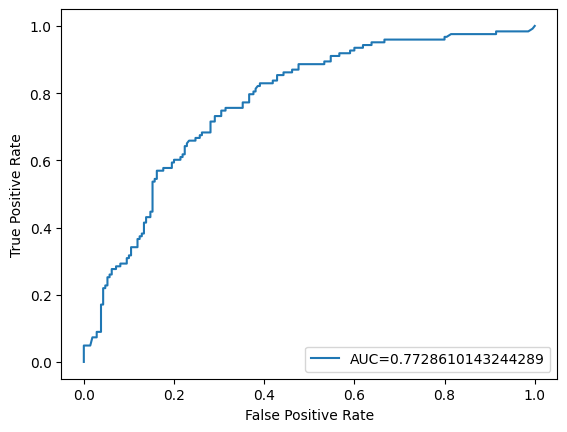

In [ ]:
# prediction
preds = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  preds)
auc = roc_auc_score(y_test, preds)
print("AUC="+str(auc))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
importance = pd.DataFrame({'feature': X_cols, 'importance': model.feature_importance()})
types = ['MIDAS_text','MIDAS_cross','MIDAS_image','model_type_O','model_type_U','model_type_V']
for t in types:
    importance[f'is_{t}']= 0
    importance.loc[importance['feature'].str.contains(t), f'is_{t}']= 1
importance = importance[importance["importance"]>=1].reset_index(drop=True)
categories = [f"is_{tp}" for tp in types]
imp_grp = importance.groupby(categories)
imp_feat = imp_grp["feature"].nunique().reset_index(drop=False)
imp_sum = imp_grp["importance"].sum().reset_index(drop=False)
print(imp_feat)
print("==================")
print(imp_sum)
imp_feat.to_csv(f"{DRIVE_DIR}/{VILIO_DIR}/{EXPORT_DIR}/all_optuna_nunique_{RS}.csv", index=False)
imp_sum.to_csv(f"{DRIVE_DIR}/{VILIO_DIR}/{EXPORT_DIR}/all_optuna_occurrences_{RS}.csv", index=False)

    is_MIDAS_text  is_MIDAS_cross  is_MIDAS_image  is_model_type_O  \
0               0               0               0                0   
1               0               0               0                0   
2               0               0               0                0   
3               0               0               0                1   
4               0               0               1                0   
5               0               0               1                0   
6               0               0               1                0   
7               0               0               1                1   
8               0               1               0                0   
9               0               1               0                0   
10              0               1               0                0   
11              0               1               0                1   
12              1               0               0                0   
13              1   

#### for each model type

Model O
AUC=0.5988721804511278


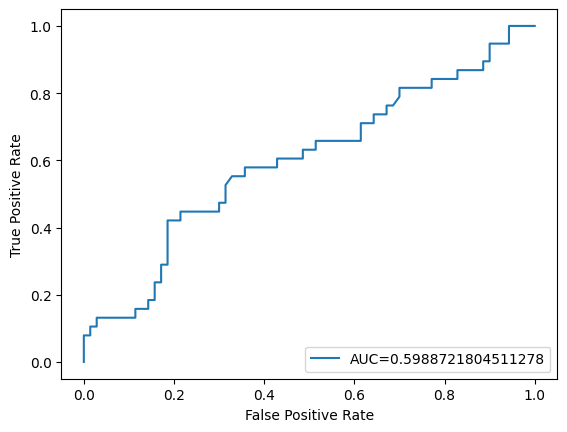

Model U
AUC=0.7348171152518979


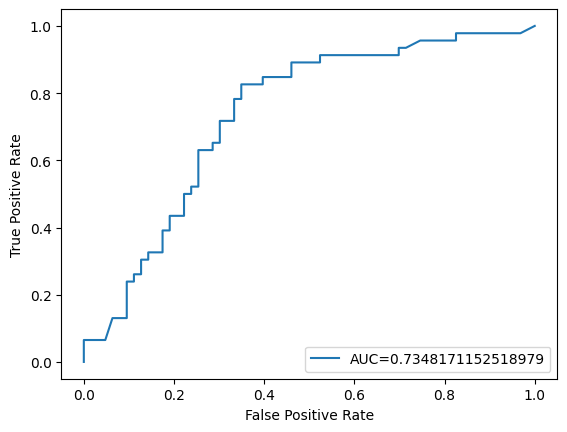

Model V
AUC=0.9132534132534131


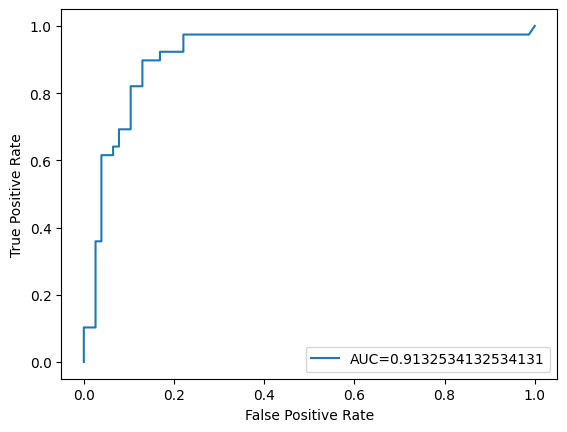

In [ ]:
aucs = {}
df_test["preds"] = model.predict(X_test)
for tp in ["O","U","V"]:
    print(f"Model {tp}")
    if tp=="O":
        df_plot_scope = df_test[(df_test[f"model_type_U"]==0)&(df_test[f"model_type_V"]==0)].reset_index(drop=True)
    else:
        df_plot_scope = df_test[df_test[f"model_type_{tp}"]==1].reset_index(drop=True)
    fpr, tpr, _ = roc_curve(df_plot_scope[f"{plot_cols[PRED_COL]}_category"],  df_plot_scope["preds"])
    auc = roc_auc_score(df_plot_scope[f"{plot_cols[PRED_COL]}_category"],  df_plot_scope["preds"])
    print("AUC="+str(auc))
    aucs[tp] = auc
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

In [ ]:
print(aucs)

{'O': 0.5988721804511278, 'U': 0.7348171152518979, 'V': 0.9132534132534131}


Model O
[train, eval, test] size: [(200, 76), (50, 76), (108, 76)]


feature_fraction, val_score: 0.637684: 100%|##########| 7/7 [00:00<00:00, 53.59it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	Train's binary_logloss: 0.576932	Valid's binary_logloss: 0.641475
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.653159	Valid's binary_logloss: 0.657267
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.653159	Valid's binary_logloss: 0.657267
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.654825	Valid's binary_logloss: 0.650468
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.653159	Valid's binary_logloss: 0.657267
Training 

num_leaves, val_score: 0.637684:  10%|#         | 2/20 [00:00<00:00, 84.07it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


num_leaves, val_score: 0.637684:  15%|#5        | 3/20 [00:00<00:00, 66.47it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


num_leaves, val_score: 0.637684:  20%|##        | 4/20 [00:00<00:00, 63.82it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.637684:  55%|#####5    | 11/20 [00:00<00:00, 57.88it/s]

Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stop

num_leaves, val_score: 0.637684:  60%|######    | 12/20 [00:00<00:00, 57.30it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


num_leaves, val_score: 0.637684:  70%|#######   | 14/20 [00:00<00:00, 57.30it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


num_leaves, val_score: 0.637684:  75%|#######5  | 15/20 [00:00<00:00, 57.30it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


num_leaves, val_score: 0.637684: 100%|##########| 20/20 [00:00<00:00, 52.08it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	Train's binary_logloss: 0.647189	Valid's binary_logloss: 0.644042
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


bagging, val_score: 0.637684:  10%|#         | 1/10 [00:00<00:00, 45.09it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.650274	Valid's binary_logloss: 0.638092
Training until validation scores don't improve for 5 rounds

bagging, val_score: 0.632509:  20%|##        | 2/10 [00:00<00:00, 45.38it/s]


Early stopping, best iteration is:
[2]	Train's binary_logloss: 0.64201	Valid's binary_logloss: 0.632509


bagging, val_score: 0.632509:  30%|###       | 3/10 [00:00<00:00, 41.87it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


bagging, val_score: 0.632509:  40%|####      | 4/10 [00:00<00:00, 41.47it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.630023	Valid's binary_logloss: 0.637684


bagging, val_score: 0.623577:  80%|########  | 8/10 [00:00<00:00, 40.42it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	Train's binary_logloss: 0.64217	Valid's binary_logloss: 0.6414
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.630085	Valid's binary_logloss: 0.630174
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.624407	Valid's binary_logloss: 0.623577
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.624407	Valid's binary_logloss: 0.623577


bagging, val_score: 0.623577:  90%|######### | 9/10 [00:00<00:00, 40.42it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.630085	Valid's binary_logloss: 0.630174


bagging, val_score: 0.623577: 100%|##########| 10/10 [00:00<00:00, 38.29it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.630085	Valid's binary_logloss: 0.630174


feature_fraction_stage2, val_score: 0.621763:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


feature_fraction_stage2, val_score: 0.621763:  33%|###3      | 2/6 [00:00<00:00, 55.31it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.623684	Valid's binary_logloss: 0.624975


feature_fraction_stage2, val_score: 0.621763: 100%|##########| 6/6 [00:00<00:00, 54.01it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.624407	Valid's binary_logloss: 0.623577
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.624407	Valid's binary_logloss: 0.623577
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.624407	Valid's binary_logloss: 0.623577
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.623684	Valid's binary_logloss: 0.624975


regularization_factors, val_score: 0.621763:   5%|5         | 1/20 [00:00<00:00, 36.87it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds

regularization_factors, val_score: 0.621763:  10%|#         | 2/20 [00:00<00:00, 41.29it/s]


Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  15%|#5        | 3/20 [00:00<00:00, 39.27it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  25%|##5       | 5/20 [00:00<00:00, 41.97it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  40%|####      | 8/20 [00:00<00:00, 41.97it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  45%|####5     | 9/20 [00:00<00:00, 41.97it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  50%|#####     | 10/20 [00:00<00:00, 36.88it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  55%|#####5    | 11/20 [00:00<00:00, 36.88it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  60%|######    | 12/20 [00:00<00:00, 36.88it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  75%|#######5  | 15/20 [00:00<00:00, 35.13it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  80%|########  | 16/20 [00:00<00:00, 35.13it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763:  85%|########5 | 17/20 [00:00<00:00, 35.13it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.630753	Valid's binary_logloss: 0.629895
Training until validation scores don't improve for 5 rounds

regularization_factors, val_score: 0.621763:  95%|#########5| 19/20 [00:00<00:00, 35.63it/s]


Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


regularization_factors, val_score: 0.621763: 100%|##########| 20/20 [00:00<00:00, 36.55it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	Train's binary_logloss: 0.625606	Valid's binary_logloss: 0.621763


min_data_in_leaf, val_score: 0.621763: 100%|##########| 5/5 [00:00<00:00, 61.33it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.580636	Valid's binary_logloss: 0.64511
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	Train's binary_logloss: 0.666707	Valid's binary_logloss: 0.656763
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	Train's binary_logloss: 0.618537	Valid's binary_logloss: 0.626671
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.670932	Valid's binary_logloss: 0.65601
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	Train's binary_logloss: 0.611646	Valid's binary_logloss: 0.636458
{'verbose': -1, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.1, 'seed': 1991, 'deterministic': True, 'force_ro


AUC=0.6140625000000001


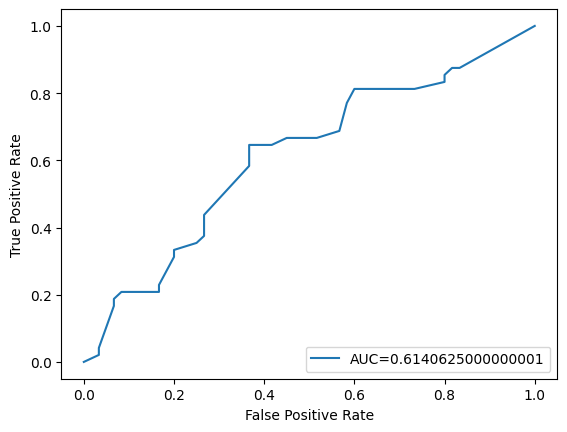

------------------
   is_MIDAS_text  is_MIDAS_cross  is_MIDAS_image  is_submodel_OV50  \
0              0               0               0                 0   
1              0               0               1                 0   
2              0               1               0                 0   
3              1               0               0                 0   

   is_submodel_O50  is_submodel_O36  is_submodel_U72  is_submodel_U50  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   

   is_submodel_U36  is_submodel_V45  is_submodel_V90  is_submodel_V135  \
0                0                0                0                 0   
1                0                0                0                 0   
2                0                0       

feature_fraction, val_score: 0.574605: 100%|##########| 7/7 [00:00<00:00, 50.80it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.464298	Valid's binary_logloss: 0.578194
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	Train's binary_logloss: 0.46951	Valid's binary_logloss: 0.611852
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.444195	Valid's binary_logloss: 0.614473
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.503471	Valid's binary_logloss: 0.60615
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	Train's binary_logloss: 0.525687	Valid's binary_logloss: 0.59039
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	Train's binary_logloss: 0.41673	Valid's binary_logloss: 0.612244
Training u


num_leaves, val_score: 0.574605:  10%|#         | 2/20 [00:00<00:00, 56.31it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605


num_leaves, val_score: 0.574605:  15%|#5        | 3/20 [00:00<00:00, 46.33it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605


num_leaves, val_score: 0.574605:  40%|####      | 8/20 [00:00<00:00, 42.51it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605


num_leaves, val_score: 0.574605:  45%|####5     | 9/20 [00:00<00:00, 42.51it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.574605:  55%|#####5    | 11/20 [00:00<00:00, 37.69it/s]

Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605


num_leaves, val_score: 0.574605:  80%|########  | 16/20 [00:00<00:00, 37.17it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.522532	Valid's binary_logloss: 0.583562
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605


num_leaves, val_score: 0.574605:  85%|########5 | 17/20 [00:00<00:00, 37.17it/s]

Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.574605: 100%|##########| 20/20 [00:00<00:00, 39.75it/s]


Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605


bagging, val_score: 0.574605:  50%|#####     | 5/10 [00:00<00:00, 35.40it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	Train's binary_logloss: 0.507441	Valid's binary_logloss: 0.586819
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	Train's binary_logloss: 0.496608	Valid's binary_logloss: 0.582401
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	Train's binary_logloss: 0.53594	Valid's binary_logloss: 0.599299
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.505138	Valid's binary_logloss: 0.574605
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	Train's binary_logloss: 0.453902	Valid's binary_logloss: 0.575426


bagging, val_score: 0.574287:  80%|########  | 8/10 [00:00<00:00, 37.87it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20]	Train's binary_logloss: 0.507457	Valid's binary_logloss: 0.59187
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	Train's binary_logloss: 0.497672	Valid's binary_logloss: 0.576744
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


bagging, val_score: 0.574287: 100%|##########| 10/10 [00:00<00:00, 35.05it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	Train's binary_logloss: 0.530326	Valid's binary_logloss: 0.595283
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.50923	Valid's binary_logloss: 0.583319


feature_fraction_stage2, val_score: 0.574287:  67%|######6   | 4/6 [00:00<00:00, 64.73it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.515563	Valid's binary_logloss: 0.592372
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	Train's binary_logloss: 0.539475	Valid's binary_logloss: 0.593606
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.512432	Valid's binary_logloss: 0.588533
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	Train's binary_logloss: 0.511287	Valid's binary_logloss: 0.589008


feature_fraction_stage2, val_score: 0.574287: 100%|##########| 6/6 [00:00<00:00, 55.89it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	Train's binary_logloss: 0.548592	Valid's binary_logloss: 0.59306
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	Train's binary_logloss: 0.538676	Valid's binary_logloss: 0.592448


regularization_factors, val_score: 0.574287:   5%|5         | 1/20 [00:00<00:00, 35.26it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  15%|#5        | 3/20 [00:00<00:00, 31.36it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  25%|##5       | 5/20 [00:00<00:00, 32.55it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  30%|###       | 6/20 [00:00<00:00, 32.55it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  35%|###5      | 7/20 [00:00<00:00, 32.55it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  45%|####5     | 9/20 [00:00<00:00, 31.09it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  50%|#####     | 10/20 [00:00<00:00, 31.09it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287


regularization_factors, val_score: 0.574287:  60%|######    | 12/20 [00:00<00:00, 28.68it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430887	Valid's binary_logloss: 0.574287
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.574286:  65%|######5   | 13/20 [00:00<00:00, 28.68it/s]

Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430892	Valid's binary_logloss: 0.574286
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430907	Valid's binary_logloss: 0.574282


regularization_factors, val_score: 0.574281:  75%|#######5  | 15/20 [00:00<00:00, 28.38it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430913	Valid's binary_logloss: 0.574281


regularization_factors, val_score: 0.574277:  80%|########  | 16/20 [00:00<00:00, 28.38it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430928	Valid's binary_logloss: 0.574277
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430928	Valid's binary_logloss: 0.574277


regularization_factors, val_score: 0.574276:  90%|######### | 18/20 [00:00<00:00, 24.37it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430936	Valid's binary_logloss: 0.574276
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.574276: 100%|##########| 20/20 [00:02<00:00,  7.13it/s]


Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430922	Valid's binary_logloss: 0.574279
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	Train's binary_logloss: 0.430932	Valid's binary_logloss: 0.574276


min_data_in_leaf, val_score: 0.574276: 100%|##########| 5/5 [00:00<00:00, 51.45it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	Train's binary_logloss: 0.39152	Valid's binary_logloss: 0.61963
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	Train's binary_logloss: 0.592093	Valid's binary_logloss: 0.608218
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	Train's binary_logloss: 0.526444	Valid's binary_logloss: 0.593274
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.680793	Valid's binary_logloss: 0.690097
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	Train's binary_logloss: 0.453433	Valid's binary_logloss: 0.585602
{'verbose': -1, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.1, 'seed': 1991, 'deterministic': True, 'forc

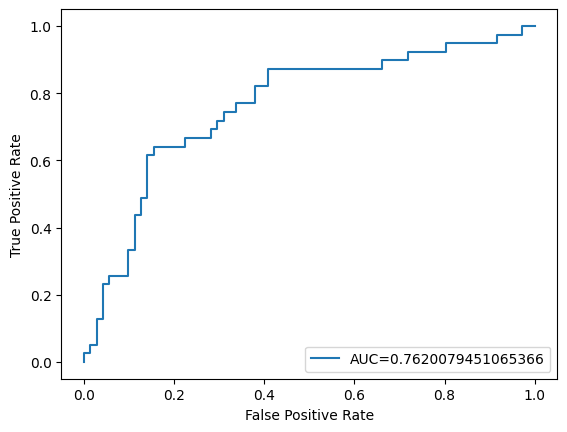

------------------
   is_MIDAS_text  is_MIDAS_cross  is_MIDAS_image  is_submodel_OV50  \
0              0               0               0                 0   
1              0               0               0                 0   
2              0               0               0                 0   
3              0               0               1                 0   
4              0               0               1                 0   
5              0               0               1                 0   
6              0               1               0                 0   
7              1               0               0                 0   
8              1               0               0                 0   

   is_submodel_O50  is_submodel_O36  is_submodel_U72  is_submodel_U50  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                1         

feature_fraction, val_score: 0.434325:  57%|#####7    | 4/7 [00:00<00:00, 36.89it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	Train's binary_logloss: 0.162893	Valid's binary_logloss: 0.457232
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	Train's binary_logloss: 0.145075	Valid's binary_logloss: 0.453535
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	Train's binary_logloss: 0.16105	Valid's binary_logloss: 0.447343
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	Train's binary_logloss: 0.135047	Valid's binary_logloss: 0.434325
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	Train's binary_logloss: 0.155563	Valid's binary_logloss: 0.467317


feature_fraction, val_score: 0.434325:  86%|########5 | 6/7 [00:00<00:00, 36.89it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	Train's binary_logloss: 0.150116	Valid's binary_logloss: 0.434776
Training until validation scores don't improve for 5 rounds


feature_fraction, val_score: 0.433602: 100%|##########| 7/7 [00:00<00:00, 30.28it/s]


Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


num_leaves, val_score: 0.433602:  15%|#5        | 3/20 [00:00<00:00, 27.75it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


num_leaves, val_score: 0.433602:  20%|##        | 4/20 [00:00<00:00, 27.75it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


num_leaves, val_score: 0.433602:  25%|##5       | 5/20 [00:00<00:00, 27.75it/s]

Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.433602:  40%|####      | 8/20 [00:00<00:00, 23.46it/s]

Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


num_leaves, val_score: 0.433602:  45%|####5     | 9/20 [00:00<00:00, 24.50it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


num_leaves, val_score: 0.433602:  50%|#####     | 10/20 [00:00<00:00, 24.50it/s]

Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.433602:  65%|######5   | 13/20 [00:00<00:00, 23.91it/s]

Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


num_leaves, val_score: 0.433602:  75%|#######5  | 15/20 [00:00<00:00, 24.23it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.433602:  90%|######### | 18/20 [00:00<00:00, 24.27it/s]

Early stopping, best iteration is:
[76]	Train's binary_logloss: 0.217124	Valid's binary_logloss: 0.493574
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds


num_leaves, val_score: 0.433602: 100%|##########| 20/20 [00:00<00:00, 24.52it/s]


Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602


bagging, val_score: 0.433602:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.433602:  30%|###       | 3/10 [00:00<00:00, 25.97it/s]

Early stopping, best iteration is:
[49]	Train's binary_logloss: 0.316046	Valid's binary_logloss: 0.532509
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	Train's binary_logloss: 0.199436	Valid's binary_logloss: 0.490044
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	Train's binary_logloss: 0.50159	Valid's binary_logloss: 0.63436
Training until validation scores don't improve for 5 rounds


bagging, val_score: 0.433602:  50%|#####     | 5/10 [00:00<00:00, 25.97it/s]

Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.119838	Valid's binary_logloss: 0.433602
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	Train's binary_logloss: 0.448548	Valid's binary_logloss: 0.572546
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	Train's binary_logloss: 0.438874	Valid's binary_logloss: 0.60806


bagging, val_score: 0.433602:  90%|######### | 9/10 [00:00<00:00, 27.03it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	Train's binary_logloss: 0.401051	Valid's binary_logloss: 0.582337
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	Train's binary_logloss: 0.349605	Valid's binary_logloss: 0.566143
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	Train's binary_logloss: 0.313533	Valid's binary_logloss: 0.563103


bagging, val_score: 0.433602: 100%|##########| 10/10 [00:00<00:00, 26.98it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	Train's binary_logloss: 0.440858	Valid's binary_logloss: 0.593108


feature_fraction_stage2, val_score: 0.410505:  33%|###3      | 2/6 [00:00<00:00, 28.27it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	Train's binary_logloss: 0.162893	Valid's binary_logloss: 0.457232
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102176	Valid's binary_logloss: 0.410505


feature_fraction_stage2, val_score: 0.410505: 100%|##########| 6/6 [00:00<00:00, 35.23it/s]


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	Train's binary_logloss: 0.171348	Valid's binary_logloss: 0.467035
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	Train's binary_logloss: 0.253571	Valid's binary_logloss: 0.492709
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	Train's binary_logloss: 0.22527	Valid's binary_logloss: 0.49791
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	Train's binary_logloss: 0.155563	Valid's binary_logloss: 0.467317


regularization_factors, val_score: 0.410505:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.410505:  10%|#         | 2/20 [00:00<00:00, 20.04it/s]

Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410519
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  20%|##        | 4/20 [00:00<00:00, 21.57it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  25%|##5       | 5/20 [00:00<00:00, 21.57it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  30%|###       | 6/20 [00:00<00:00, 20.29it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.410505:  40%|####      | 8/20 [00:00<00:00, 20.29it/s]

Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  45%|####5     | 9/20 [00:00<00:00, 19.81it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  55%|#####5    | 11/20 [00:00<00:00, 19.81it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	Train's binary_logloss: 0.127285	Valid's binary_logloss: 0.430873


regularization_factors, val_score: 0.410505:  60%|######    | 12/20 [00:00<00:00, 19.37it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102176	Valid's binary_logloss: 0.410505
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102176	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  75%|#######5  | 15/20 [00:00<00:00, 18.80it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  80%|########  | 16/20 [00:00<00:00, 18.80it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.410505:  85%|########5 | 17/20 [00:00<00:00, 19.66it/s]

Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


regularization_factors, val_score: 0.410505:  95%|#########5| 19/20 [00:00<00:00, 19.66it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102178	Valid's binary_logloss: 0.410518
Training until validation scores don't improve for 5 rounds


regularization_factors, val_score: 0.410505: 100%|##########| 20/20 [00:01<00:00, 19.99it/s]


Early stopping, best iteration is:
[75]	Train's binary_logloss: 0.102177	Valid's binary_logloss: 0.410511


min_data_in_leaf, val_score: 0.410505:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	Train's binary_logloss: 0.023345	Valid's binary_logloss: 0.254543


min_data_in_leaf, val_score: 0.254543:  80%|########  | 4/5 [00:00<00:00, 16.66it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	Train's binary_logloss: 0.341051	Valid's binary_logloss: 0.558287
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	Train's binary_logloss: 0.184517	Valid's binary_logloss: 0.455768
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	Train's binary_logloss: 0.580516	Valid's binary_logloss: 0.670984
Training until validation scores don't improve for 5 rounds


min_data_in_leaf, val_score: 0.254543: 100%|##########| 5/5 [00:00<00:00, 22.60it/s]

Early stopping, best iteration is:
[49]	Train's binary_logloss: 0.0595243	Valid's binary_logloss: 0.367367
{'verbose': -1, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.1, 'seed': 1991, 'deterministic': True, 'force_row_wise': True, 'feature_pre_filter': False, 'lambda_l1': 1.398718299871122e-07, 'lambda_l2': 2.625558621605346e-06, 'num_leaves': 31, 'feature_fraction': 0.5479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 500}
------------------
AUC=0.921727395411606


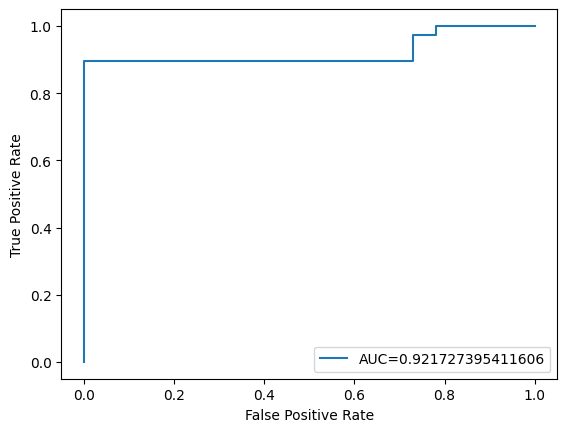

------------------
    is_MIDAS_text  is_MIDAS_cross  is_MIDAS_image  is_submodel_OV50  \
0               0               0               0                 0   
1               0               0               0                 0   
2               0               0               0                 0   
3               0               0               0                 0   
4               0               0               1                 0   
5               0               0               1                 0   
6               0               0               1                 0   
7               0               0               1                 0   
8               0               1               0                 0   
9               0               1               0                 0   
10              0               1               0                 0   
11              0               1               0                 0   
12              1               0               0         

In [ ]:
aucs2 = {}
for tp in ["O","U","V"]:
    print(f"Model {tp}")
    params = {
        'verbose': -1,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'seed': RS,
        'deterministic':True,
        'force_row_wise':True
    }
    if tp=="O":
        model_scope = (df_analysis[f"model_type_U"]==0)&(df_analysis[f"model_type_V"]==0)
    else:
        model_scope = df_analysis[f"model_type_{tp}"]==1
    df_analysis_scope = df_analysis[model_scope].reset_index(drop=True)

    df_train_eval, df_test = train_test_split(df_analysis_scope, random_state=RS, test_size=0.3)
    df_train, df_eval = train_test_split(df_train_eval, random_state=RS, test_size=0.2)
    print(f"[train, eval, test] size: {[df_train.shape, df_eval.shape, df_test.shape]}")
    X_train_eval = df_train_eval[X_cols].values
    y_train_eval = df_train_eval[f"{plot_cols[PRED_COL]}_category"].values
    X_train, X_eval, X_test = df_train[X_cols].values, df_eval[X_cols].values, df_test[X_cols].values
    y_train = df_train[f"{plot_cols[PRED_COL]}_category"].values
    y_eval = df_eval[f"{plot_cols[PRED_COL]}_category"].values
    y_test = df_test[f"{plot_cols[PRED_COL]}_category"].values

    lgb_train = opt_lgb.Dataset(X_train, y_train)
    lgb_valid = opt_lgb.Dataset(X_eval, y_eval, reference=lgb_train)
    lgb_test = opt_lgb.Dataset(X_test, y_test, reference=lgb_train)

    lgb_results = {}
    model = opt_lgb.LightGBMTuner(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['Train', 'Valid'],
        num_boost_round=500,
        early_stopping_rounds=5,
        evals_result=lgb_results,
        verbosity=-1,
        verbose_eval=-1,
        optuna_seed=RS,
    )
    model.run()
    model = model.get_best_booster()
    print(model.params)
    print("------------------")

    preds = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test,  preds)
    auc = roc_auc_score(y_test, preds)
    print("AUC="+str(auc))
    aucs2[tp] = auc
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    print("------------------")

    importance = pd.DataFrame({'feature': X_cols, 'importance': model.feature_importance()})
    submodels = df_vilio["submodel"].unique().tolist()
    submodel_cols = [f"submodel_{model}" for model in submodels]
    types = ['MIDAS_text','MIDAS_cross','MIDAS_image']+submodel_cols
    for t in types:
        importance[f'is_{t}']= 0
        importance.loc[importance['feature'].str.contains(t), f'is_{t}']= 1
    importance = importance[importance["importance"]>=1].reset_index(drop=True)
    categories = [f"is_{tp}" for tp in types]
    imp_grp = importance.groupby(categories)
    imp_feat = imp_grp["feature"].nunique().reset_index(drop=False)
    imp_sum = imp_grp["importance"].sum().reset_index(drop=False)
    print(imp_feat)
    print("------------------")
    print(imp_sum)
    print("==================")
    imp_feat.to_csv(f"{DRIVE_DIR}/{VILIO_DIR}/{EXPORT_DIR}/{tp}_indv_optuna_nunique_{RS}.csv", index=False)
    imp_sum.to_csv(f"{DRIVE_DIR}/{VILIO_DIR}/{EXPORT_DIR}/{tp}_indv_optuna_occurrences_{RS}.csv", index=False)

In [ ]:
print(aucs2)

{'O': 0.6140625000000001, 'U': 0.7620079451065366, 'V': 0.921727395411606}


## export

In [ ]:
dfs = lgb_results2df()
print(dfs.keys())
for ky in dfs.keys():
    print(ky)
    print(dfs[ky].shape)

dict_keys(['_indv_optuna_occurrences_', '_indv_optuna_nunique_'])
_indv_optuna_occurrences_
(189, 15)
_indv_optuna_nunique_
(189, 15)


In [ ]:
key_cols = dfs["_indv_optuna_occurrences_"].drop("importance", axis=1).columns.tolist()
df_merged = dfs["_indv_optuna_nunique_"].merge(dfs["_indv_optuna_occurrences_"].set_index(key_cols), left_on=key_cols, right_index=True)
df_merged.head()

,model_type,seed,is_MIDAS_text,is_MIDAS_cross,is_MIDAS_image,is_submodel_OV50,is_submodel_O50,is_submodel_O36,is_submodel_U72,is_submodel_U50,is_submodel_U36,is_submodel_V45,is_submodel_V90,is_submodel_V135,feature,importance
0,O,1987,0,0,0,0,0,0,0,0,0,0,0,0,4,12
1,O,1987,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,O,1987,0,0,0,1,0,0,0,0,0,0,0,0,1,3
3,O,1987,0,0,1,0,0,0,0,0,0,0,0,0,4,7
4,O,1987,0,0,1,0,0,1,0,0,0,0,0,0,1,2


In [ ]:
df_merged.to_csv(f"{DRIVE_DIR}/{VILIO_DIR}/{EXPORT_DIR}/indv_optuna_merged.csv", index=False)